# Mini Projet SSL for Anomaly Detection

In [6]:
# Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import opendatasets as od
import kagglehub
import os

# Create a directory to store the datasets
os.makedirs("datasets", exist_ok=True)

mvtec_ad_url = kagglehub.dataset_download("ipythonx/mvtec-ad")
auto_vi_url = "https://zenodo.org/api/records/10459003/files-archive"  

od.download(mvtec_ad_url, data_dir='datasets/MVTec_AD')
od.download(auto_vi_url, data_dir='datasets/AutoVI')

Using downloaded and verified file: datasets/MVTec_AD\mvtec_anomaly_detection.tar.xz
Using downloaded and verified file: datasets/AutoVI\10459003.zip


### Chargement et prétraitement des images de MVTec AD

In [19]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mvtec_path = 'datasets/MVTec_AD'
categories = ['bottle', 'hazelnut', 'capsule', 'toothbrush']

def load_mvtec_images(category, split='train'):
    images = []
    labels = []
    
    split_path = os.path.join(mvtec_path, category, split)
    
    if split == 'train':
        good_path = os.path.join(split_path, 'good')
        for img_name in os.listdir(good_path):
            img_path = os.path.join(good_path, img_name)
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img)
            labels.append(0)
    
    else:
        for anomaly_type in os.listdir(split_path):
            anomaly_path = os.path.join(split_path, anomaly_type)
            for img_name in os.listdir(anomaly_path):
                img_path = os.path.join(anomaly_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = transform(img)
                images.append(img)
                
                if anomaly_type == 'good':
                    labels.append(0)
                else:
                    labels.append(1)

    return torch.stack(images), torch.tensor(labels)

train_images, train_labels = [], []
test_images, test_labels = [], []

for category in categories:
    imgs, lbls = load_mvtec_images(category, split='train')
    train_images.append(imgs)
    train_labels.append(lbls)
    
    imgs, lbls = load_mvtec_images(category, split='test')
    test_images.append(imgs)
    test_labels.append(lbls)

train_images = torch.cat(train_images)
train_labels = torch.cat(train_labels)
test_images = torch.cat(test_images)
test_labels = torch.cat(test_labels)

train_dataloader_MVTec = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_dataloader_MVTec = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from MVTec AD.")


Loaded 879 training images and 367 test images from MVTec AD.


### Chargement et prétraitement des images de AutoVI

In [20]:
autovi_path = 'datasets/AutoVI/engine_wiring'

# Function to load images from a specific split (train or test)
def load_autovi_images(split='train'):
    images = []
    labels = []
    
    # Define the path based on the split (train/test)
    split_path = os.path.join(autovi_path, split)
    
    # List all subfolders (categories)
    categories = os.listdir(split_path)
    
    for category in categories:
        category_path = os.path.join(split_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path).convert('RGB')  
            img = transform(img)  
            images.append(img)
            
            # Use the index of the category as a label (you can adjust this if needed)
            labels.append(categories.index(category))
    
    return torch.stack(images), torch.tensor(labels)  

# Load AutoVI dataset images (train and test)
train_images, train_labels = load_autovi_images(split='train')
test_images, test_labels = load_autovi_images(split='test')

# Create DataLoaders for AutoVI train and test sets
train_dataloader_auto = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_dataloader_auto = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

# Check loaded data
print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from AutoVI.")


Loaded 285 training images and 607 test images from AutoVI.


### Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647059..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7490196..0.427451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.45882356].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.7960

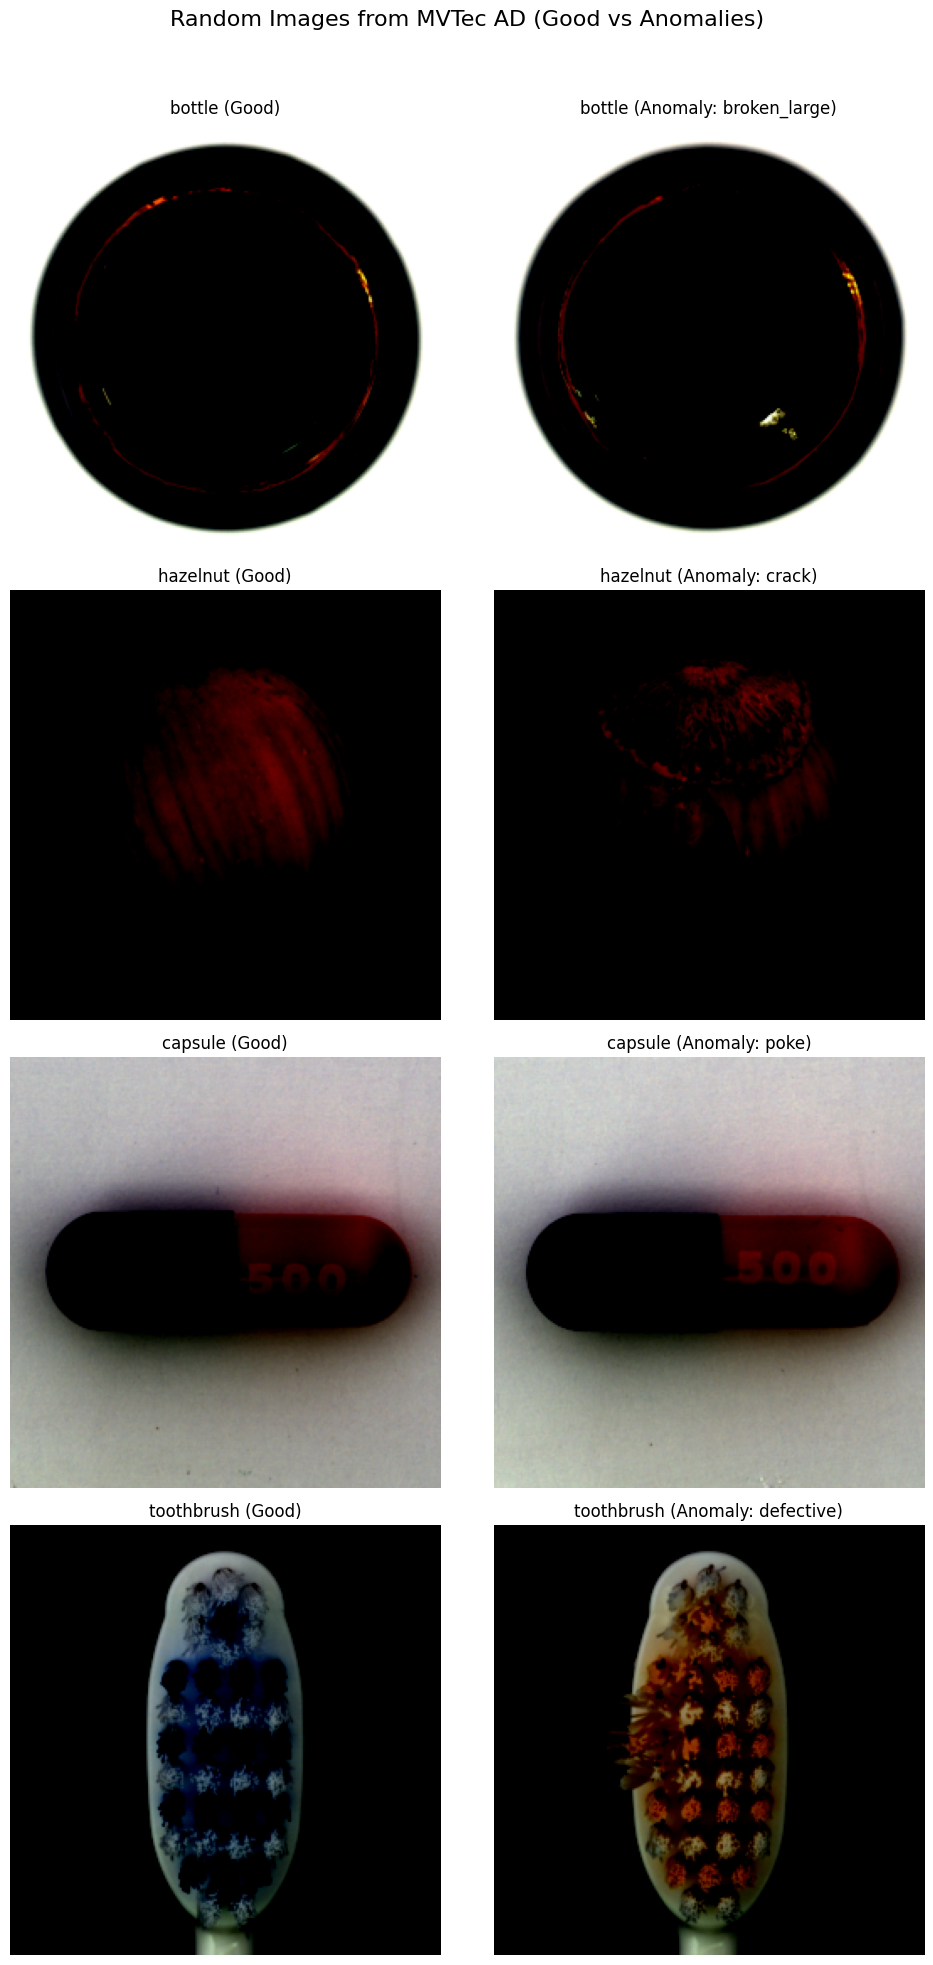

In [17]:
import random

def display_random__MVTec(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(len(category_list), 2, figsize=(10, 5 * len(category_list)))  
    fig.suptitle(f'Random Images from {dataset_name} (Good vs Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, category, split)
        
        # Load a random "good" image
        good_path = os.path.join(split_path, 'good')
        good_image = random.choice(os.listdir(good_path))
        good_image_path = os.path.join(good_path, good_image)
        img_good = Image.open(good_image_path).convert('RGB')
        img_good = transform(img_good)
        
        # Display the "good" image
        axs[i, 0].imshow(img_good.permute(1, 2, 0)) 
        axs[i, 0].set_title(f"{category} (Good)")
        axs[i, 0].axis('off')
        
        # Load a random anomalous image (choose a random anomaly type)
        anomalies = [d for d in os.listdir(split_path) if d != 'good']
        anomaly_type = random.choice(anomalies)
        anomaly_path = os.path.join(split_path, anomaly_type)
        anomaly_image = random.choice(os.listdir(anomaly_path))
        anomaly_image_path = os.path.join(anomaly_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        axs[i, 1].imshow(img_anomalous.permute(1, 2, 0))  
        axs[i, 1].set_title(f"{category} (Anomaly: {anomaly_type})")
        axs[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage for MVTec AD dataset
mvtec_path = 'datasets/MVTec_AD'
categories_mvtec = ['bottle', 'hazelnut', 'capsule', 'toothbrush']
display_random_MVTec(categories_mvtec, "MVTec AD", mvtec_path, transform, split='test')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


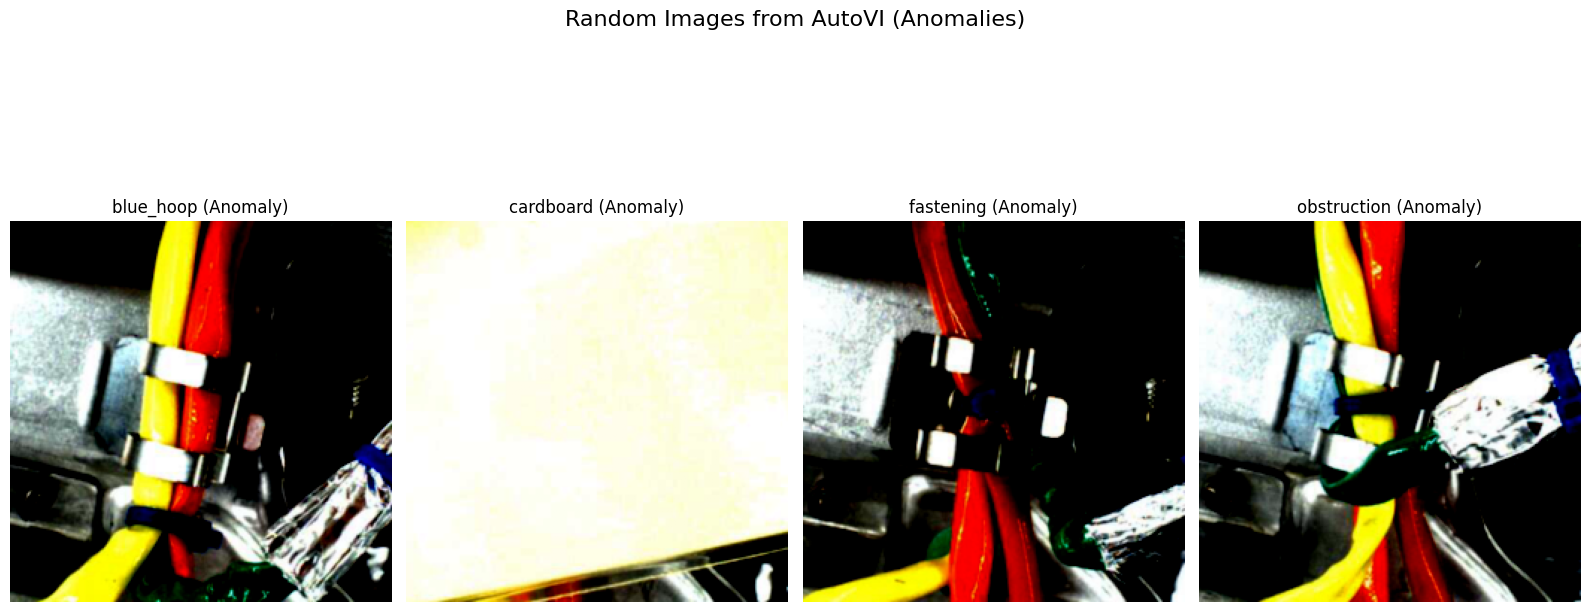

In [24]:
def display_random_autovi(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(1, len(category_list), figsize=(16, 8))  # Create subplot (1 row, 1 column per category)
    fig.suptitle(f'Random Images from {dataset_name} (Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, split, category)
        
        # Load a random anomalous image
        anomaly_image = random.choice(os.listdir(split_path))
        anomaly_image_path = os.path.join(split_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        axs[i].imshow(img_anomalous.permute(1, 2, 0))  # Rearrange dimensions for display
        axs[i].set_title(f"{category} (Anomaly)")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage for AutoVI dataset
autovi_path = 'datasets/AutoVI/engine_wiring'
categories_autovi = ['blue_hoop', 'cardboard', 'fastening', 'obstruction']  # Categories in AutoVI
display_random_autovi(categories_autovi, "AutoVI", autovi_path, transform, split='test')


### Premier Modèle SSL